In [231]:
import os
import pickle
import json
import matplotlib.pyplot as plt
import argparse
import itertools

from tensorboardX import SummaryWriter
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
import yaml
from bisect import bisect
import numpy as np

from visdialch.data.dataset import VisDialDataset
from visdialch.encoders import Encoder
from visdialch.decoders import Decoder
from visdialch.metrics import SparseGTMetrics, NDCG
from visdialch.model import EncoderDecoderModel
from visdialch.utils.checkpointing import CheckpointManager, load_checkpoint

import datetime
import os
import pickle
import code

In [235]:
with open('checkpoints/2019-06-27T19:03:26.880078/testbatch_1.pkl', 'rb') as file:
    batch_dict, attention = pickle.load(file)

In [236]:
# =============================================================================
#   SETUP DATASET, DATALOADER, MODEL, CRITERION, OPTIMIZER, SCHEDULER
# =============================================================================
config = yaml.load(open('configs/lf_disc_faster_rcnn_x101.light.newfeatures.yml'))
train_dataset = VisDialDataset(
    config["dataset"],
    "data/visdial_1.0_train.json",
    overfit=10,
    in_memory=False,
    return_options=True if config["model"]["decoder"] == "disc" else False,
    add_boundary_toks=False if config["model"]["decoder"] == "disc" else True,
)
print('Length of train dataset:', len(train_dataset))
n_batches_per_epoch = int(np.ceil(len(train_dataset) / config["solver"]["batch_size"]))

/usr/cs/public/project_vis/visdialciss/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


KeyboardInterrupt: 

In [237]:
import re
from PIL import Image

In [78]:
available_image_ids = {
    float(re.findall(r'([\d]+)\.jpg', f)[0])
    :
    os.path.join(f'../visdial-challenge-starter-pytorch/data/images/{split}/{f}')
    for split in (
        'train2014',
        'test2014',
        'val2014',
        'VisualDialog_test2018',
        'VisualDialog_val2018',
    )
    for f in os.listdir(f'../visdial-challenge-starter-pytorch/data/images/{split}/')
    }
len(available_image_ids)

174126

In [239]:
attention.shape

(320, 64)

In [240]:
attention = attention.reshape((32, 10, 64))

In [241]:
attention.shape, batch_dict['ques'].shape

((32, 10, 64), (32, 10, 20))

In [242]:
def ids_to_sentence(ids):
    return' '.join([
        train_dataset.vocabulary.index2word[_] 
        for _ in ids if _!=train_dataset.vocabulary.PAD_INDEX]).capitalize()

In [243]:
def get_image(img_id):
    img_path = available_image_ids.get(img_id)
    image = Image.open(img_path)
    return image

In [244]:
img = get_image(9.0)

In [246]:
def plot_attention(image, ques, attention_plot):
    temp_image = np.array(image)

    fig = plt.figure(figsize=(20, 15))
    len_result = len(ques)
    
    for l, q in enumerate(ques):
        temp_att = np.resize(attention_plot[l], (8, 8))
        title = ids_to_sentence(q)
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(title)
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [247]:
batch_dict.keys()

dict_keys(['img_ids', 'img_feat', 'ques', 'hist', 'ans_in', 'ans_out', 'ques_len', 'hist_len', 'ans_len', 'num_rounds', 'opt', 'opt_len', 'ans_ind', 'gt_relevance', 'round_id'])

In [248]:
ids_to_sentence(batch_dict['hist'][0][0])

'A woman with reflective paint under her eyes is on her hands and knees on a white surfboard floating on the water'

In [249]:
batch_dict['ans_in'][0]

array([[ 24,  69,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [304,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 42,  72, 210, 100,   5,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [304, 135,  24,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 24,  44,  34,  14,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 24,  22,  96,  14,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [ 10,  21,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [194]:
for proposal in batch_dict['opt'][0]:
    print('PROPOSAL--')
    for __ in proposal:
        print(ids_to_sentence(__))

PROPOSAL--
Yes
Ca n't tell
Brown
1
Daytime
Yes , full color photo
Color
On gravel and grass
Not sure , there ’ s natural light
It 's just gray
I ca n't tell
All of them yes
Yes , it 's a full color photo
Cardboard box
Yes , just 1
Yes 1 main photo of a horse there are a few to the side but not really a main
Red , yellow , and blue
6 including the trailer
Yellow , red , and blue
There is a curtain covering it , so i am unable to tell
White
4
Silver
Yes it is in color
Yes , the image is in color
The lamps are off
There is no tv visible
Yes , the bathroom is cluttered with a number of <unk> items
Dark wood with light wood in the center
Brown and tan
No
No people
Blue
Green
I can not tell
No it 's not
Yes it 's in color
Looks like it but ca n't tell
No lake
The picture is very gray , hard to tell
It is in color
I see an image of a baseball game behind the umpire at home base
No , it is off
The mug is teal
Unable to see outside
No , just the giraffes
A little light brown
The orange
It looks

'A woman sits on a bench holding a guitar in her lap'

In [207]:
batch_dict.keys()

dict_keys(['img_ids', 'img_feat', 'ques', 'hist', 'ans_in', 'ans_out', 'ques_len', 'hist_len', 'ans_len', 'num_rounds', 'opt', 'opt_len', 'ans_ind', 'gt_relevance', 'round_id'])

In [230]:
batch_dict['hist_len']

array([[ 13,  21,  29,  36,  46,  56,  63,  77,  85,  98],
       [ 12,  25,  36,  45,  55,  71,  82,  91,  99, 110],
       [ 25,  33,  42,  57,  89, 110, 118, 126, 133, 141],
       [  9,  17,  33,  47,  56,  76,  84,  92, 100, 120],
       [ 10,  18,  26,  35,  45,  53,  59,  76,  88, 101],
       [ 10,  16,  24,  32,  44,  52,  62,  71,  80,  88],
       [ 15,  25,  33,  41,  48,  60,  72,  79,  90,  99],
       [ 29,  40,  51,  60,  69,  78,  86,  95, 102, 112],
       [ 12,  27,  37,  46,  56,  66,  77,  90, 105, 114],
       [ 10,  18,  28,  43,  51,  61,  69,  76,  84,  92]])

In [227]:
os.listdir('checkpoints/')

['.commit-412aa7d',
 '2019-06-25T20:52:38.554878',
 '2019-06-26T21:32:27.044770',
 '2019-06-26T21:43:16.856135',
 '2019-06-26T21:46:31.909863',
 '2019-06-26T21:59:17.709658',
 '2019-06-26T22:04:13.598389',
 '2019-06-26T22:07:44.819097',
 '2019-06-27T18:00:34.429271',
 '2019-06-27T18:09:25.719923',
 '2019-06-27T18:16:25.800116',
 '2019-06-27T18:26:06.929006',
 '2019-06-27T18:28:24.989364',
 '2019-06-27T18:32:36.651835',
 '2019-06-27T18:35:44.623533',
 '2019-06-27T18:41:16.608070',
 '2019-06-27T18:44:46.761118',
 '2019-06-27T18:51:29.710490',
 '2019-06-27T19:03:26.880078',
 'baseline',
 'config.yml',
 'events.out.tfevents.1561509496.dan417-11',
 'events.out.tfevents.1561509880.dan417-11',
 'no_pic_baseline',
 'sashank_baseline']

A group of colored boats tied up together on the water


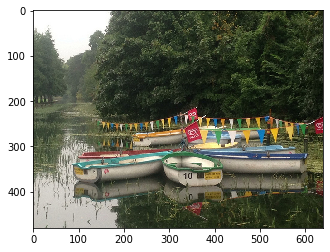

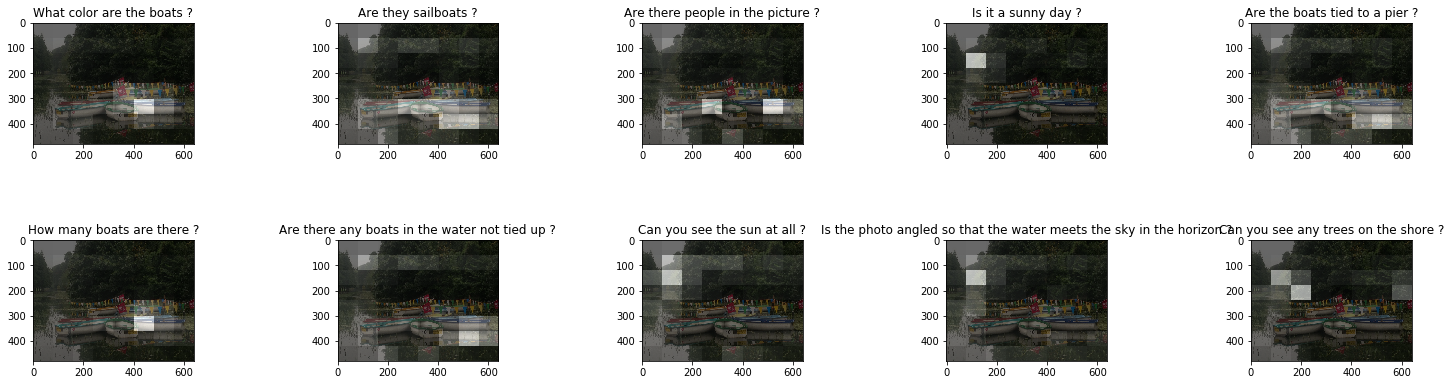

In [265]:
ix=10
print(ids_to_sentence(batch_dict['hist'][ix][0]))
plt.imshow(np.array(get_image(float(batch_dict['img_ids'][ix]))))
plot_attention(get_image(float(batch_dict['img_ids'][ix])), ques=batch_dict['ques'][ix], attention_plot=attention[ix])

In [218]:
batch_dict['hist'][0][:2, :20]

array([[   7,  589,    5,  556,   37,  285,   20, 2171,   23,    7,  525,
         292,  204,    0,    0,    0,    0,    0,    0,    0],
       [   7,  589,    5,  556,   37,  285,   20, 2171,   23,    7,  525,
         292,  204,    5,    6,   53,   15,   19,    4,   10]])

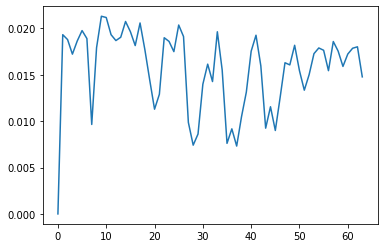

In [40]:
plt.plot(attention[11])